In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab

In [15]:
from collections import namedtuple, OrderedDict

In [16]:
def choose_encoders(n_neurons: int, dimensions: int, encoder_proportion: float, mean_fan1, mean_fan2):
    encoders = np.zeros((n_neurons, dimensions))

    fan1_end = int(n_neurons * encoder_proportion)

    for n_i in range(fan1_end):
        encoders[n_i] = mean_fan1 + np.random.normal(size=dimensions)*0.1

    for n_i in range(fan1_end, n_neurons):
        encoders[n_i] = mean_fan2 + np.random.normal(size=dimensions)*0.1
    
    return encoders

In [17]:
Act = namedtuple("act", ['fan_num', 'targ', 'act'])
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

# Effect of modifying p_fan

In [21]:
dimensions = 64
n_neurons = 1000
seed = 8

df_list = []

vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
mean_fan1 = np.mean(fan1_vecs, axis=0)
mean_fan2 = np.mean(fan2_vecs, axis=0)

stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
             "fan2": Stim(2, True, np.array(fan2_vecs)),
             "foil1": Stim(1, False, np.array(foil1_vecs)),
             "foil2": Stim(2, False, np.array(foil2_vecs))}
    

for p_fan in list(np.arange(0.7, 1.0, 0.05)):

    enc = choose_encoders(n_neurons, dimensions, p_fan, mean_fan1, mean_fan2)
    
    with nengo.Network() as model:
        ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc)
    sim = nengo.Simulator(model)
    
    acts = dict()
    for key, obj in stim_vecs.items():
        _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
        acts[key] = Act(obj.fan_num, obj.targ, act)

    for key, obj in acts.items():
        act = obj.act.flatten()
        df_list.append(pd.DataFrame({"act": list(act),
                                     "resp": obj.fan_num,
                                     "targ": obj.targ,
                                     "pfan": p_fan}))

act_df = pd.concat(df_list)

Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 

(60, 110)

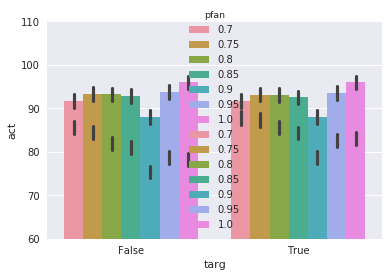

In [22]:
ax = sns.barplot(x="targ", y="act", hue="pfan", data=act_df[act_df.resp == 1])

ax = sns.barplot(x="targ", y="act", hue="pfan", data=act_df[act_df.resp == 2])
ax.set_ylim((60, 110))

Beyond a certain threshold (around `pfan=0.8`) the proportion doesn't really do much.

# Confidence intervals across vocab

In [69]:
dimensions = 64
n_neurons = 1000
p_fan = 0.85

In [75]:
df_list = []

for seed in range(10):
    vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
    mean_fan1 = np.mean(fan1_vecs, axis=0)
    mean_fan2 = np.mean(fan2_vecs, axis=0)
    
    stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
                 "fan2": Stim(2, True, np.array(fan2_vecs)),
                 "foil1": Stim(1, False, np.array(foil1_vecs)),
                 "foil2": Stim(2, False, np.array(foil2_vecs))}
    
    enc = choose_encoders(n_neurons, dimensions, p_fan, mean_fan1, mean_fan2)
    
    with nengo.Network() as model:
        ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc)
    sim = nengo.Simulator(model)
    
    acts = dict()
    for key, obj in stim_vecs.items():
        _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
        acts[key] = Act(obj.fan_num, obj.targ, act)

    for key, obj in acts.items():
        act = obj.act.flatten()
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": list(act), "resp": resp, "targ": targ, "seed": seed}))

act_df = pd.concat(df_list)

850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           
850
Building finished in 0:00:01.                                                                                           


(60, 110)

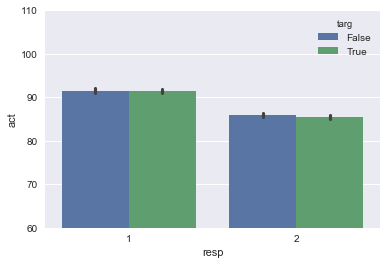

In [76]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim((60, 110))

As expected, collecting data across multiple vocabs reduces the size of the confidence intervals, making the trend clearer.

# Effect of intercept modification

I expect it to give more distinct trends

In [ ]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.85

In [3]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
mean_fan1 = np.mean(fan1_vecs, axis=0)
mean_fan2 = np.mean(fan2_vecs, axis=0)

In [6]:
encoders = choose_encoders(n_neurons, dimensions, p_fan, mean_fan1, mean_fan2)

850


In [ ]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
             "fan2": Stim(2, True, np.array(fan2_vecs)),
             "foil1": Stim(1, False, np.array(foil1_vecs)),
             "foil2": Stim(2, False, np.array(foil2_vecs))}

## Base Case

In [58]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [59]:
acts = dict()

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
    acts[key] = Act(obj.fan_num, obj.targ, act)

In [60]:
df_list = []

for key, obj in acts.items():
    act = obj.act.flatten()
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": list(act), "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

(60, 110)

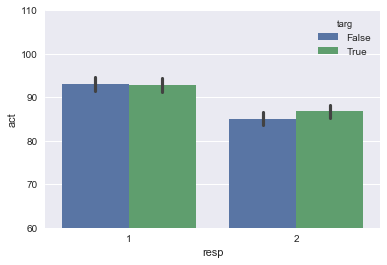

In [61]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim((60, 110))

Number of neurons basically firing for both vectors
354


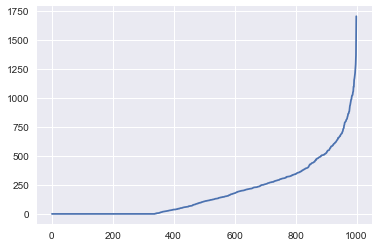

In [63]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(acts["fan1"].act, axis=0) - np.sum(acts["fan2"].act, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

## With modified intercepts

In [64]:
simi = 0.3
int_a = nengo.dists.Uniform(-1.0, -simi).sample(n_neurons // 2)
int_b = nengo.dists.Uniform(simi, 1.0).sample(n_neurons - len(int_a))
intercepts = np.concatenate((int_a, int_b))
print(intercepts.shape)

(1000,)


In [65]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders, intercepts=intercepts)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                           


In [66]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])
Act = namedtuple("act", ['fan_num', 'targ', 'act'])

stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
             "fan2": Stim(2, True, np.array(fan2_vecs)),
             "foil1": Stim(1, False, np.array(foil1_vecs)),
             "foil2": Stim(2, False, np.array(foil2_vecs))}
acts = dict()

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
    acts[key] = Act(obj.fan_num, obj.targ, act)

In [67]:
df_list = []

for key, obj in acts.items():
    act = obj.act.flatten()
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": list(act), "resp": resp, "targ": targ}))

int_act_df = pd.concat(df_list)

(60, 110)

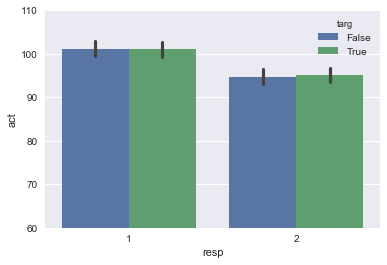

In [68]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=int_act_df)
ax.set_ylim((60, 110))

Number of neurons basically firing for both vectors
354


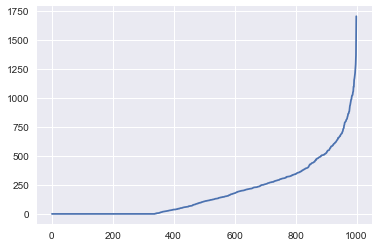

In [63]:
print("Number of neurons basically firing for both vectors")
fire_diff = np.sort(np.abs(np.sum(acts["fan1"].act, axis=0) - np.sum(acts["fan2"].act, axis=0)))
print(len(fire_diff[fire_diff < 10]))
plt.plot(fire_diff)

Does appear to make the trend stronger while also increasing the firing rate, but surprisingly doesn't decrease the amount of neurons firing for both FAN1 and FAN2. Probably because there's more overlap between the vocabularies than I originally thought?

# Demonstration of memory operating over time

In [3]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.85

In [4]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
mean_fan1 = np.mean(fan1_vecs, axis=0)
mean_fan2 = np.mean(fan2_vecs, axis=0)

In [7]:
encoders = choose_encoders(n_neurons, dimensions, p_fan, mean_fan1, mean_fan2)

In [9]:
with nengo.Network() as model:
    nd = nengo.Node(fan1_vecs[0])
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
    nengo.Connection(nd, ens)
    
    p_out = nengo.Probe(ens, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(1.0)

Building finished in 0:00:01.                                                                                                                 
Simulating finished in 0:00:01.                                                                                                               


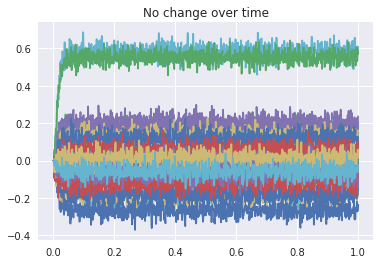

In [13]:
plt.plot(sim.trange(), spa.similarity(sim.data[p_out], vocab))
plt.title("No change over time");

# Effect of noisier encoders

In [24]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.85

In [25]:
vocab, fan1, fan1_vecs, fan2, fan2_vecs, foil1, foil1_vecs, foil2, foil2_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
mean_fan1 = np.mean(fan1_vecs, axis=0)
mean_fan2 = np.mean(fan2_vecs, axis=0)

stim_vecs = {"fan1": Stim(1, True, np.array(fan1_vecs)),
             "fan2": Stim(2, True, np.array(fan2_vecs)),
             "foil1": Stim(1, False, np.array(foil1_vecs)),
             "foil2": Stim(2, False, np.array(foil2_vecs))}

In [27]:
df_list = []

scale = 1.0

for mag in (0.09, 0.1, 0.15):
    encoders = np.zeros((n_neurons, dimensions))

    fan1_end = int(n_neurons * p_fan)

    for n_i in range(fan1_end):
        encoders[n_i] = mean_fan1 + np.random.normal(scale=scale, size=dimensions)*mag

    for n_i in range(fan1_end, n_neurons):
        encoders[n_i] = mean_fan2 + np.random.normal(scale=scale, size=dimensions)*mag
        
    with nengo.Network() as model:
        ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
    sim = nengo.Simulator(model)
    
    acts = dict()

    for key, obj in stim_vecs.items():
        _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
        acts[key] = Act(obj.fan_num, obj.targ, act)
        


    for key, obj in acts.items():
        act = obj.act.flatten()
        df_list.append(pd.DataFrame({"act": list(act),
                                     "resp": obj.fan_num,
                                     "targ": obj.targ,
                                     "noise_mag": mag,
                                     "noise_scale": scale}))

mag = 0.1

for scale in (0.9, 1.0, 1.1):
    encoders = np.zeros((n_neurons, dimensions))

    fan1_end = int(n_neurons * p_fan)

    for n_i in range(fan1_end):
        encoders[n_i] = mean_fan1 + np.random.normal(scale=scale, size=dimensions)*mag

    for n_i in range(fan1_end, n_neurons):
        encoders[n_i] = mean_fan2 + np.random.normal(scale=scale, size=dimensions)*mag
        
    with nengo.Network() as model:
        ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
    sim = nengo.Simulator(model)
    
    acts = dict()

    for key, obj in stim_vecs.items():
        _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)
        acts[key] = Act(obj.fan_num, obj.targ, act)
        


    for key, obj in acts.items():
        act = obj.act.flatten()
        df_list.append(pd.DataFrame({"act": list(act),
                                     "resp": obj.fan_num,
                                     "targ": obj.targ,
                                     "noise_mag": mag,
                                     "noise_scale": scale}))

act_df = pd.concat(df_list)

Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 
Building finished in 0:00:01.                                                                                                                 


(60, 110)

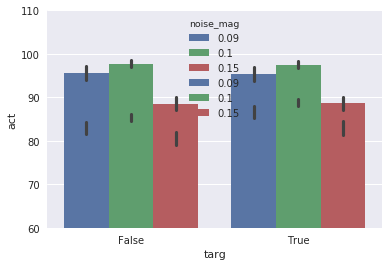

In [28]:
ax = sns.barplot(x="targ", y="act", hue="noise_mag", data=act_df[act_df.resp == 1])

ax = sns.barplot(x="targ", y="act", hue="noise_mag", data=act_df[act_df.resp == 2])
ax.set_ylim((60, 110))

(60, 110)

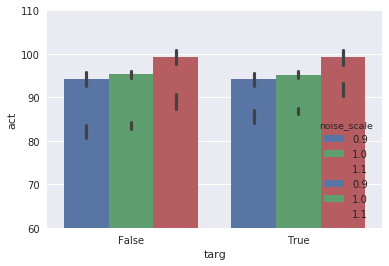

In [29]:
ax = sns.barplot(x="targ", y="act", hue="noise_scale", data=act_df[act_df.resp == 1])

ax = sns.barplot(x="targ", y="act", hue="noise_scale", data=act_df[act_df.resp == 2])
ax.set_ylim((60, 110))

The less noise in the encoder distribution, the stronger the effect.

# Effect of noisier inputs

## Representation of noisier inputs

## Effect of a noisier mean

# Effect of memory as associative

## Can you learn an associative memory off the Ensemble using PES?

## Does this intermediary ensemble change the performance of an engineered associative memory?

## Can you create a functional circuit using only this Designed Ensemble?